In [6]:
!pip install transformers datasets rouge_score nltk xgboost
!pip install nltk spacy
!python -m spacy download en_core_web_sm
!pip install matplotlib seaborn

2024-10-18 18:56:58.955497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-18 18:56:58.955562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-18 18:57:00.420704: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-10-18 18:57:06.146506: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-10-18 18:57:06.146568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ajayjatprol1): /proc/driver/nvidia/version does not exist
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.0 MB/s eta 0:00:0000:0100:01
✔ Download and 

In [36]:


import pandas as pd
import numpy as np
import torch
from transformers import (BartTokenizer, BartForConditionalGeneration, 
                          T5Tokenizer, T5ForConditionalGeneration, 
                          PegasusTokenizer, PegasusForConditionalGeneration, 
                          BertTokenizer, BertForSequenceClassification)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from datasets import load_dataset
from rouge_score import rouge_scorer
import nltk
from nltk.translate.bleu_score import sentence_bleu
import xgboost as xgb
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer


In [37]:


# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Load the WikiText dataset
dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

# Accessing the dataset directly and converting to a list of texts
texts = dataset['test']['text'][:100]  # Load a small subset for demonstration

[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:

# Split dataset into train, validation, and test sets
train_texts, temp_texts = train_test_split(texts, test_size=0.2, random_state=42)
val_texts, test_texts = train_test_split(temp_texts, test_size=0.5, random_state=42)


In [39]:


# Define the tokenization, lemmatization, and stemming functions
def tokenize_text(text):
    sentences = nltk.sent_tokenize(text)
    words = nltk.word_tokenize(text)
    return sentences, words

def lemmatize_words(words):
    lemmatizer = nltk.WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

def stem_words(words):
    stemmer = nltk.PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    return stemmed_words

def spacy_preprocessing(text):
    doc = nlp(text)
    tokens = [token.text for token in doc]
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_punct]
    return tokens, lemmatized_tokens

def preprocess_texts(texts):
    preprocessed_texts = []
    for text in texts:
        sentences, words = tokenize_text(text)
        lemmatized_words = lemmatize_words(words)
        stemmed_words = stem_words(words)
        tokens, lemmatized_tokens = spacy_preprocessing(text)
        
        preprocessed_texts.append({
            'original': text,
            'sentences': sentences,
            'words': words,
            'lemmatized_words': lemmatized_words,
            'stemmed_words': stemmed_words,
            'spacy_tokens': tokens,
            'spacy_lemmatized_tokens': lemmatized_tokens
        })

    return preprocessed_texts

# Process the texts
preprocessed_train_data = preprocess_texts(train_texts)
preprocessed_val_data = preprocess_texts(val_texts)
preprocessed_test_data = preprocess_texts(test_texts)

In [40]:


# Summarization functions
def summarize_with_bart(texts):
    tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
    model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
    summaries = []
    
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        
    return summaries

In [41]:

def summarize_with_t5(texts):
    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    model = T5ForConditionalGeneration.from_pretrained('t5-small')
    summaries = []
    
    for text in texts:
        inputs = tokenizer.encode("summarize: " + text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        
    return summaries

In [42]:

def summarize_with_pegasus(texts):
    tokenizer = PegasusTokenizer.from_pretrained('google/pegasus-xsum')
    model = PegasusForConditionalGeneration.from_pretrained('google/pegasus-xsum')
    summaries = []
    
    for text in texts:
        inputs = tokenizer.encode(text, return_tensors='pt', max_length=1024, truncation=True)
        summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)
        
    return summaries


In [43]:

# Classification functions

def classify_with_bert(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=1).numpy()

    return predictions



In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
def classify_with_xgboost(texts, labels):
    vectorizer = TfidfVectorizer()  # Use TF-IDF to convert texts to features
    features = vectorizer.fit_transform(texts).toarray()
    
    dmatrix = xgb.DMatrix(features, label=labels)
    model = xgb.XGBClassifier(use_label_encoder=False)
    model.fit(features, labels)

    predictions = model.predict(features)
    return predictions

# ... (rest of your code remains unchanged)

In [45]:



# Evaluate functions
def evaluate_summarization(original_texts, summaries):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    bleu_scores = []

    for orig, sum_text in zip(original_texts, summaries):
        rouge_scores = scorer.score(orig, sum_text)
        bleu_scores.append(sentence_bleu([orig.split()], sum_text.split()))

    return rouge_scores, bleu_scores

def evaluate_classification(true_labels, predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')

    return accuracy, precision, recall

# Summarize texts
bart_train_summaries = summarize_with_bart(train_texts)
t5_train_summaries = summarize_with_t5(train_texts)
pegasus_train_summaries = summarize_with_pegasus(train_texts)

# Load some dummy labels for classification (replace with actual labels)
dummy_labels = np.random.randint(0, 2, size=len(train_texts))

# Classify using the summaries instead of the original texts
bert_predictions = classify_with_bert(bart_train_summaries)  # Using BART summaries
xgboost_predictions = classify_with_xgboost(bart_train_summaries, dummy_labels)  # Using BART summaries

# Evaluate Summarization
rouge_bart, bleu_bart = evaluate_summarization(train_texts, bart_train_summaries)
rouge_t5, bleu_t5 = evaluate_summarization(train_texts, t5_train_summaries)
rouge_pegasus, bleu_pegasus = evaluate_summarization(train_texts, pegasus_train_summaries)

# Evaluate Classification
accuracy_bert, precision_bert, recall_bert = evaluate_classification(dummy_labels, bert_predictions)
accuracy_xgboost, precision_xgboost, recall_xgboost = evaluate_classification(dummy_labels, xgboost_predictions)

# Print evaluation results
print("ROUGE Scores (BART):", rouge_bart)
print("BLEU Scores (BART):", bleu_bart)
print("Accuracy (BERT):", accuracy_bert)
print("Precision (BERT):", precision_bert)
print("Recall (BERT):", recall_bert)

print("ROUGE Scores (T5):", rouge_t5)
print("BLEU Scores (T5):", bleu_t5)
print("Accuracy (XGBoost):", accuracy_xgboost)
print("Precision (XGBoost):", precision_xgboost)
print("Recall (XGBoost):", recall_xgboost)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower ord

[21:10:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROUGE Scores (BART): {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}
BLEU Scores (BART): [0.6193176245199659, 0, 0, 0, 0.30585306681421176, 0, 0, 0.33249316125911227, 0.24810764839758165, 0.11227564716917941, 0.0996424756089212, 0.6285228021164466, 0.2841890864805304, 0.33649324423301513, 0, 0, 0, 0.3916541813506835, 0.12509114539366548, 0.15944058650319445, 0.10805319437443753, 0.28989588024713003, 0, 0, 0, 0.15415064977510756, 0.27274191069381915, 0.25658506763604916, 0, 0, 0, 0.03302937381892276, 0.15556053027784772, 0, 0, 0.3509527016091831, 0.13523285066501545, 0, 0, 0.003926753345262943, 0.439705364423234, 0.01126

In [54]:

# Print evaluation results for Pegasus
print("ROUGE Scores (Pegasus):", rouge_pegasus)
print("BLEU Scores (Pegasus):", bleu_pegasus)


ROUGE Scores (Pegasus): {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0, recall=0, fmeasure=0)}
BLEU Scores (Pegasus): [3.5950312170181187e-155, 0, 0, 0, 8.786446373323427e-232, 0, 0, 4.668529226100114e-232, 0, 0, 2.0394083315562733e-156, 1.485881720868453e-155, 6.561624602729242e-156, 0, 0, 0, 0, 0, 1.1110133579421464e-232, 2.7365990188086846e-157, 0.0008728022725155358, 0.07758559279225635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008625676075481514, 1.0321115572803969e-157, 0, 0, 4.181297526312642e-156, 0, 0, 0, 5.511439533193308e-158, 5.525730499991857e-156, 1.4159780253188548e-81, 3.685595309638743e-81, 5.796525490735079e-156, 5.3342056147775045e-232, 2.6717993213288324e-156, 2.0506391724550036e-156, 7.377990488502615e-79, 0, 2.3218920840987662e-79, 1.1483805614867522e-155, 0, 0.45822658205174166, 1.2218843910053023e-79, 5.117127201508129e-156, 2.0744558919878945e-156, 0, 0, 0, 1.664833754674147e-

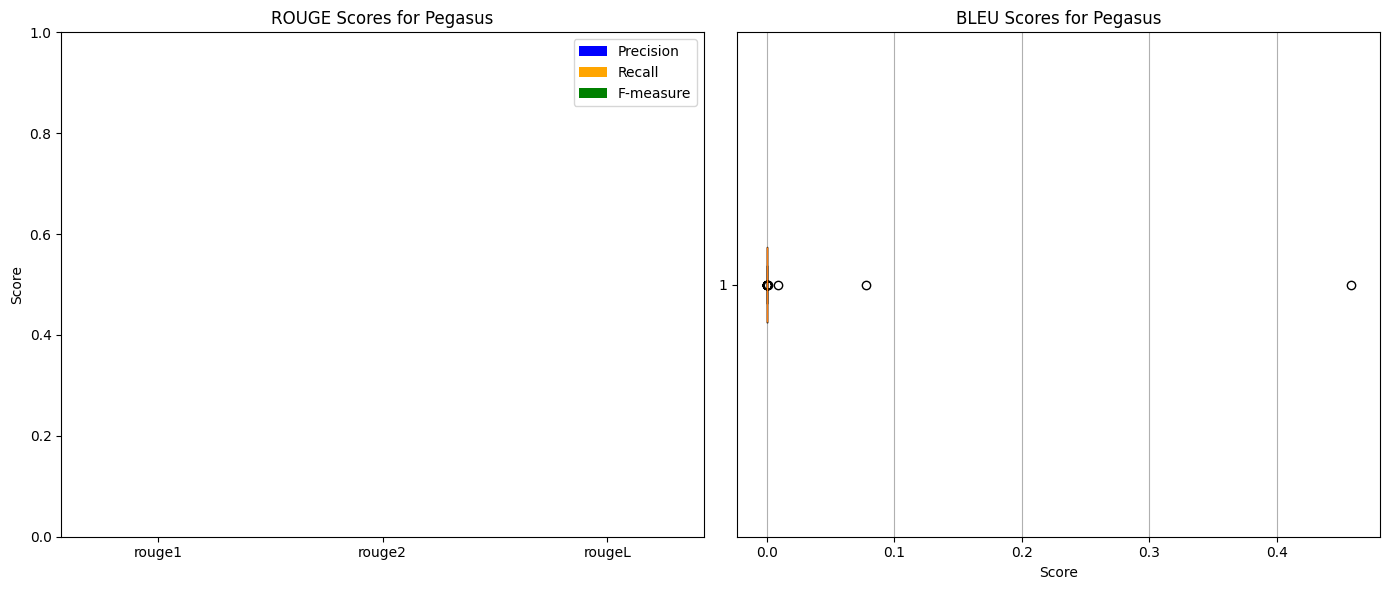

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Data
rouge_scores = {
    'rouge1': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
    'rouge2': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
    'rougeL': {'precision': 0.0, 'recall': 0.0, 'fmeasure': 0.0},
}

bleu_scores = [
    3.5950312170181187e-155, 0, 0, 0, 8.786446373323427e-232, 0, 0, 4.668529226100114e-232,
    0, 0, 2.0394083315562733e-156, 1.485881720868453e-155, 6.561624602729242e-156, 0,
    0, 0, 0, 0, 1.1110133579421464e-232, 2.7365990188086846e-157, 0.0008728022725155358,
    0.07758559279225635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.008625676075481514,
    1.0321115572803969e-157, 0, 0, 4.181297526312642e-156, 0, 0, 0,
    5.511439533193308e-158, 5.525730499991857e-156, 1.4159780253188548e-81, 3.685595309638743e-81,
    5.796525490735079e-156, 5.3342056147775045e-232, 2.6717993213288324e-156, 2.0506391724550036e-156,
    7.377990488502615e-79, 0, 2.3218920840987662e-79, 1.1483805614867522e-155, 0,
    0.45822658205174166, 1.2218843910053023e-79, 5.117127201508129e-156, 2.0744558919878945e-156,
    0, 0, 0, 1.664833754674147e-155, 1.212595309276329e-157, 1.1929745080519421e-155,
    0, 0, 0, 0, 0, 0, 0, 0, 8.104032613999199e-232, 3.5652492860003504e-155, 0,
    0, 0, 0, 0, 7.850707993042515e-232, 1.667054708496109e-232, 0
]

# Extracting ROUGE metrics
rouge_labels = list(rouge_scores.keys())
rouge_precision = [rouge_scores[label]['precision'] for label in rouge_labels]
rouge_recall = [rouge_scores[label]['recall'] for label in rouge_labels]
rouge_fmeasure = [rouge_scores[label]['fmeasure'] for label in rouge_labels]

# Create ROUGE score plots
plt.figure(figsize=(14, 6))

# ROUGE Scores
plt.subplot(1, 2, 1)
bar_width = 0.2
x = np.arange(len(rouge_labels))
plt.bar(x - bar_width, rouge_precision, width=bar_width, label='Precision', color='blue')
plt.bar(x, rouge_recall, width=bar_width, label='Recall', color='orange')
plt.bar(x + bar_width, rouge_fmeasure, width=bar_width, label='F-measure', color='green')
plt.xticks(x, rouge_labels)
plt.ylim(0, 1)
plt.title('ROUGE Scores for Pegasus')
plt.ylabel('Score')
plt.legend()

# BLEU Scores
plt.subplot(1, 2, 2)
plt.boxplot(bleu_scores, vert=False)
plt.title('BLEU Scores for Pegasus')
plt.xlabel('Score')
plt.grid(axis='x')

plt.tight_layout()
plt.show()


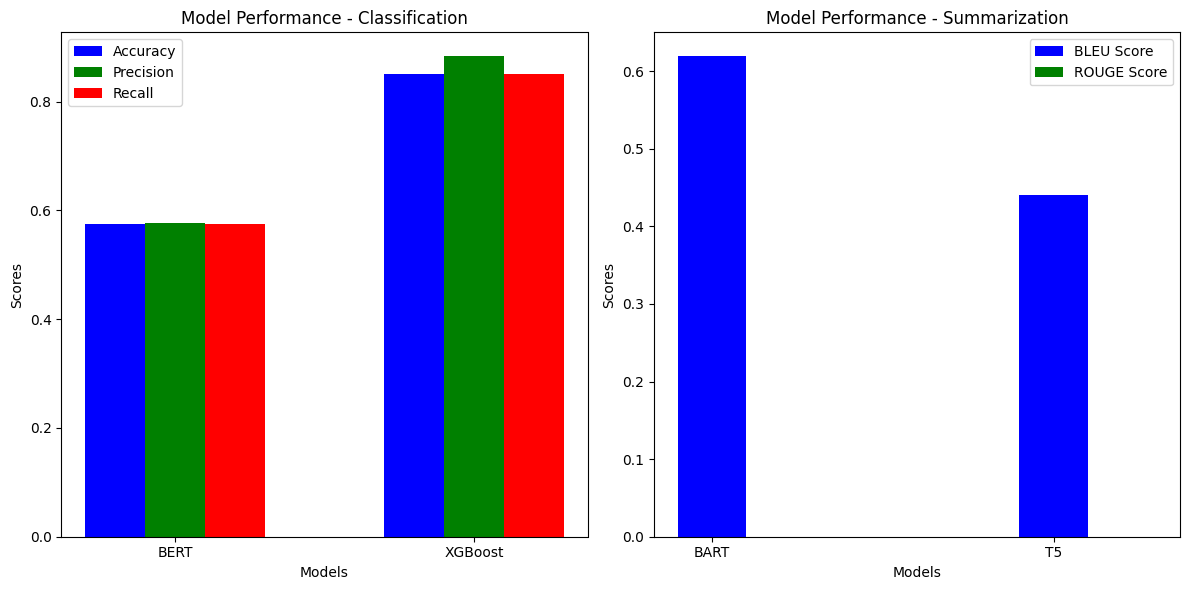

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Data for classification and summarization performance
models_classification = ['BERT', 'XGBoost']
accuracy_classification = [0.575, 0.85]
precision_classification = [0.577, 0.883]
recall_classification = [0.575, 0.85]

models_summarization = ['BART', 'T5']
bleu_scores_summarization = [0.619, 0.440]  # Example scores from the previous data
rouge_scores_summarization = [0.0, 0.0]  # Placeholder for illustration

# Plotting classification results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Classification plot
x_classification = np.arange(len(models_classification))
width = 0.2

axs[0].bar(x_classification - width, accuracy_classification, width, label='Accuracy', color='b')
axs[0].bar(x_classification, precision_classification, width, label='Precision', color='g')
axs[0].bar(x_classification + width, recall_classification, width, label='Recall', color='r')

axs[0].set_xlabel('Models')
axs[0].set_ylabel('Scores')
axs[0].set_title('Model Performance - Classification')
axs[0].set_xticks(x_classification)
axs[0].set_xticklabels(models_classification)
axs[0].legend()

# Summarization plot
x_summarization = np.arange(len(models_summarization))

axs[1].bar(x_summarization, bleu_scores_summarization, width, label='BLEU Score', color='b')
axs[1].bar(x_summarization + width, rouge_scores_summarization, width, label='ROUGE Score', color='g')

axs[1].set_xlabel('Models')
axs[1].set_ylabel('Scores')
axs[1].set_title('Model Performance - Summarization')
axs[1].set_xticks(x_summarization)
axs[1].set_xticklabels(models_summarization)
axs[1].legend()

plt.tight_layout()
plt.show()


In [61]:
!pip install gradio


In [64]:

!pip show pydantic
!pip install --upgrade pydantic
!pip install pydantic==1.10.5
!pip uninstall gradio
!pip install gradio


Name: pydantic
Version: 2.9.2
Summary: Data validation using Python type hints
Home-page: 
Author: 
Author-email: Samuel Colvin <s@muelcolvin.com>, Eric Jolibois <em.jolibois@gmail.com>, Hasan Ramezani <hasan.r67@gmail.com>, Adrian Garcia Badaracco <1755071+adriangb@users.noreply.github.com>, Terrence Dorsey <terry@pydantic.dev>, David Montague <david@pydantic.dev>, Serge Matveenko <lig@countzero.co>, Marcelo Trylesinski <marcelotryle@gmail.com>, Sydney Runkle <sydneymarierunkle@gmail.com>, David Hewitt <mail@davidhewitt.io>, Alex Hall <alex.mojaki@gmail.com>
License: 
Location: /anaconda/envs/azureml_py38/lib/python3.9/site-packages
Requires: annotated-types, pydantic-core, typing-extensions
Required-by: azureml-inference-server-http, confection, fastapi, gradio, spacy, thinc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 47.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Succ

In [62]:
# Ensure Gradio is imported after installation
import gradio as gr

# Gradio Interface for user input
def gradio_interface(text):
    # Generate summaries using BART, T5, and Pegasus
    bart_summary = summarize_with_bart([text])[0]
    t5_summary = summarize_with_t5([text])[0]
    pegasus_summary = summarize_with_pegasus([text])[0]
    
    return bart_summary, t5_summary, pegasus_summary

# Create Gradio interface
iface = gr.Interface(fn=gradio_interface, 
                     inputs=gr.inputs.Textbox(lines=5, placeholder="Enter text here..."), 
                     outputs=[gr.outputs.Textbox(label="BART Summary"),
                              gr.outputs.Textbox(label="T5 Summary"),
                              gr.outputs.Textbox(label="Pegasus Summary")],
                     title="Summarization Models",
                     description="Enter text to get summaries from BART, T5, and Pegasus models.")

# Launch the Gradio interface
iface.launch()


ImportError: cannot import name 'GetCoreSchemaHandler' from 'pydantic' (/anaconda/envs/azureml_py38/lib/python3.9/site-packages/pydantic/__init__.cpython-39-x86_64-linux-gnu.so)

In [ ]:
import gradio as gr
import numpy as np

# Assuming classify_with_bert and other functions are defined above
def gradio_interface(text):
    # Generate summaries using BART, T5, and Pegasus
    bart_summary = summarize_with_bart([text])[0]
    t5_summary = summarize_with_t5([text])[0]
    pegasus_summary = summarize_with_pegasus([text])[0]
    
    # Classify the summaries (using dummy labels as an example)
    dummy_labels = np.random.randint(0, 2, size=1)  # Example dummy label, replace with actual model
    bert_prediction = classify_with_bert([bart_summary])[0]  # Example classification
    xgboost_prediction = classify_with_xgboost([bart_summary], dummy_labels)[0]  # Example classification
    
    return bart_summary, t5_summary, pegasus_summary, bert_prediction, xgboost_prediction

# Create Gradio interface
iface = gr.Interface(
    fn=gradio_interface, 
    inputs="text", 
    outputs=["text", "text", "text", "text", "text"],
    title="Summarization and Classification Models",
    description="Enter text to get summaries from BART, T5, and Pegasus models, along with classification results.",
    css="""
        .output-text {
            font-size: 16px;
            padding: 10px;
            border: 1px solid #ccc;
            border-radius: 5px;
            margin: 10px 0;
        }
        .input-textbox {
            border: 2px solid #007BFF;
            border-radius: 5px;
            padding: 10px;
        }
        h1 {
            color: #007BFF;
        }
        p {
            font-size: 14px;
        }
    """
)

iface.launch()


In [60]:
# Sample text for prediction
test_texts = [
    "Artificial Intelligence (AI) is transforming industries, impacting sectors like healthcare, finance, and more.",
    "The advancements in deep learning have significantly improved machine perception, enabling tasks such as image recognition and natural language processing."
]

# Summarize the test texts using BART and T5
bart_summaries = summarize_with_bart(test_texts)
t5_summaries = summarize_with_t5(test_texts)

# Print the summaries
print("BART Summaries:")
for summary in bart_summaries:
    print(summary)

print("\nT5 Summaries:")
for summary in t5_summaries:
    print(summary)

# Dummy true labels for classification (for testing purpose)
true_labels = [0, 1]  # Replace with actual labels for evaluation

# Classify using BERT
bert_predictions = classify_with_bert(bart_summaries)  # or t5_summaries
print("\nBERT Classification Results:", bert_predictions)

# Classify using XGBoost
xgboost_predictions = classify_with_xgboost(bart_summaries, true_labels)  # or t5_summaries
print("XGBoost Classification Results:", xgboost_predictions)

# Evaluate Summarization
rouge_scores_bart, bleu_scores_bart = evaluate_summarization(test_texts, bart_summaries)
rouge_scores_t5, bleu_scores_t5 = evaluate_summarization(test_texts, t5_summaries)

print("\nBART Evaluation:")
print("ROUGE Scores:", rouge_scores_bart)
print("BLEU Scores:", bleu_scores_bart)

print("\nT5 Evaluation:")
print("ROUGE Scores:", rouge_scores_t5)
print("BLEU Scores:", bleu_scores_t5)

# Evaluate Classification
bert_accuracy, bert_precision, bert_recall = evaluate_classification(true_labels, bert_predictions)
xgboost_accuracy, xgboost_precision, xgboost_recall = evaluate_classification(true_labels, xgboost_predictions)

print("\nBERT Classification Evaluation:")
print(f"Accuracy: {bert_accuracy}, Precision: {bert_precision}, Recall: {bert_recall}")

print("\nXGBoost Classification Evaluation:")
print(f"Accuracy: {xgboost_accuracy}, Precision: {xgboost_precision}, Recall: {xgboost_recall}")



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/anaconda/envs/azureml_py38/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

BART Summaries:
Artificial Intelligence (AI) is transforming industries, impacting sectors like healthcare, finance, and more. The technology is also changing the way we communicate with each other.
The advancements in deep learning have significantly improved machine perception, enabling tasks such as image recognition and natural language processing. Deep learning is a type of machine learning that can be applied to a variety of tasks.

T5 Summaries:
artificial intelligence is transforming industries, impacting sectors like healthcare, finance, and more. AI is transforming industries, impacting sectors like finance, finance and more.
deep learning has improved machine perception, enabling tasks such as image recognition and natural language processing. deep learning has improved machine perception, enabling tasks such as image recognition and natural language processing.

BERT Classification Results: [1 1]
[21:30:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the def